FIrst step in every **Autometic Speech Recognition (ASR)** system is the feature extraction from an input audio signal. Goal in this article is to describe how can we transform an input audio signal wave into a sequence of feature vectors which can be send to classifiation models or deep neural network models for classifying the phonems spoken in the audio.  There are many representation of extracting features from asignal wave . One of the popular technique is **Mel Frequency Cepstral Coeficients (MFCC)**.  We will explore the MFCC feature extraction in detail.

Below figure shows the steps involved in the feature extraction process.  
<img src='Images/MFCC_Steps.png' style='width:800px' align='left'>

#### Loading Input Signal 

We will explore each step in detail with running an example.For this we will need to load a sample audio clip (OSR_us_000_0010_8k.wav) of duration approx 33 seconds. To load an digitized audio signal we will use scipy.

In [1]:
from scipy.io import wavfile
fs, signal = wavfile.read('Sample_Sounds\OSR_us_000_0010_8k.wav')

print('Sampling Rate of the audio signal {} Hz '.format(fs))
print('Samples : ', signal)
print('Total Number of Samples in the audio signal : ', len(signal))
time = len(signal)/fs
print('Signal Duration in Sec : ', time)

Sampling Rate of the audio signal 8000 Hz 
Samples :  [ -919 -1314 -1049 ...  -330  -320  -300]
Total Number of Samples in the audio signal :  268985
Signal Duration in Sec :  33.623125


Sampling rate of the input signal is 8000Hz meaning 8000 samples have been measured per seconds while converting the analog representation of signal into digital representation.In total 268985 samples have been measured. We can calculate the time duration deviding total number of samples by sampling rate. Our digitized audio signal duration is approx 33 seconds.

#### Plotting Input Signal  

Lets plot the imported audio signal where x axis corresponds to time and y axis xorresponds to aplitude. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(5,5))
x = np.linspace(0, time, len(signal))
y = signal
plt.plot(x,y)
plt.tight_layout(True)
plt.xlabel('Time-->')
plt.ylabel('Amplitude-->')
plt.show()

<Figure size 500x500 with 1 Axes>

#### MFCC Step 1 : Preemphasizing  

The first step in MFCC feature extraction is **Preemphasis** which boosts amount of energy in high frequencies. It has been observed that when we speak vowel , the audio has higher energy at lower frequencies and lower energy at higher frequencies. This drops of energies across different frequencies is called **spectral tilt**. So the audio signal is passed through the preemphasis phase to increase the energy at higher frequencies. Because increasing energy means increasing information out of the signal wave at higher frequencies. Preemphasis is a **high pass filter** (filter which allow passing through a signal with a frequency higher than a certain cutoff frequency) and the equation is $y[t] = x[t] - \alpha . x[t-1]$ where $0.9 \leq \alpha \leq 1.0$  

Lets send our input signal through the preemphasis filter to increase energy at higher frequencies. We will use $\alpha = 0.97$

In [3]:
alpha = 0.97 
signal = signal[1:] - (alpha * signal[:-1])
print('Emphesized Signal ', signal)

Emphesized Signal  [-4.2257e+02  2.2558e+02 -1.2847e+02 ... -6.0200e+00  1.0000e-01
  1.0400e+01]


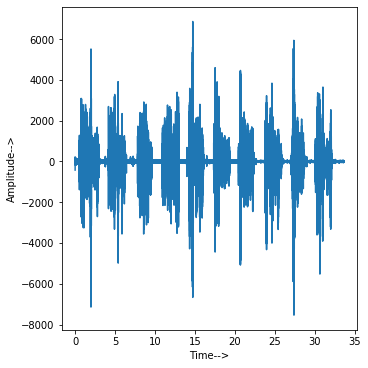

In [4]:
plt.figure(figsize=(5,5))
x = np.linspace(0, time, len(signal))
y = signal
plt.plot(x,y)
plt.tight_layout(True)
plt.xlabel('Time-->')
plt.ylabel('Amplitude-->')
plt.show()

#### MFCC Step 2 - Windowing and Framing a Signal

##### Framing

An audio signal constantly changes over time. So to capture informations from signal , it needs to be stationary. Normaly it has been asumed that over a very short period of time say 20 - 40ms signal is statistically stationary. So we need to devide a long signal into such short signals of duration 20- 40ms each. These short signal window is caleed a **frame**. and this process is known as **Framing**. Frame duration is considered to be between 20 to 40 ms. A typical frame duration used is 25ms.  

Each frame duration is 25ms. And sampling rate is 8000 samples per second in our input sound wave. Hence total number of samples in each frame (25ms window) would be (8000 * 0.025) = 200 samples.

In [5]:
frame_duration = 0.025 # In Seconds
frame_length = int(frame_duration * fs)
print('Each frame would have {} samples in the window of 25ms'.format(frame_length))

Each frame would have 200 samples in the window of 25ms


Lets plot 1st frame (25ms window) of length 200 samples.

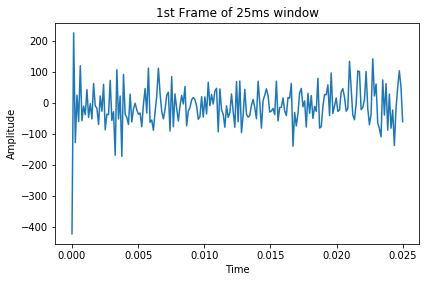

In [6]:
x = np.linspace(0,0.025,200)
y = signal[0:200]
plt.title('1st Frame of 25ms window')
plt.plot(x,y)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.tight_layout(True)
plt.show()

<img src='Images/Frame_Overlaping.png' style='width:400px' align='right'>
In practice an input signal is segmented into overlapping frames to keep the continuity between frames and to reduce the loss of informations at the edges of frames. Normally between 40% to 50% of overlapping is added between each adjucent frames. In time the overlapping duration is roughly between 10 to 12 ms is c onsidered. This overlapp is nothing but the difference between the left edges of each sucessive frames.It is known as **Frame Shift (in time)** or **Frame Step (in sample)**. In other words it is the number of samples after the start of previous frame that the next frame should begin. The figure at right illustrates the overlapping frame concept.     

  

We will use **frame_shift = 10ms**. If sampling rate is 8000 samples per second then number of samples in 10ms would be (0.010 * 8000 = 80) samples. 
So in our example sound wave, we have **frame_length = 200 samples** and **frame_step = 80 samples**. Which means 1st frame starts at sample 0 and ends at sample 200. Seconds frame should start at sample 80 and should end at sample 280 (80 +200). Third frame should starts at sample 160 and should ends at sample 360 (160 + 200) and so on untill the end of the signal is recahed. 

Each frame has an overlapping window of 120 samples with each of its next frame.So out of 200 samples 120 overlapping samples and thereby each frame carrying unique information within boundry of 80 samples only. **So the number of frames we need is (total number of samples / frame step)**


In [7]:
frame_shift = 0.010
frame_step = int(fs * frame_shift)
print('Frame Step is {} samples each frame'.format(frame_step))

Frame Step is 80 samples each frame


In [8]:
import math

total_sample_count = len(signal)

if total_sample_count < frame_length:
    frame_count = 1
else:
    frame_count = 1 + int(math.ceil((total_sample_count - frame_length) / frame_step))

print('Input Signal of sample count {} can be segmented into {} Frames of length {} each. '.format(total_sample_count,frame_count, frame_length))

Input Signal of sample count 268984 can be segmented into 3361 Frames of length 200 each. 


If the new sample count ((number of frames - 1 )* frame step) goes bigger than actual sample count then the input signal needs to be zero padded.  In this example we get 3361 frames so new sample count is ((3361 - 1)* 80 = 269000)) samples which is greater than actual sample count (268984). So the input signal of sample count 268984 has to be zero padded to get same sample count as 269000. Therefore zero pading length should be (269000 - 268984 = 16).

In [9]:
new_sample_count = ((frame_count - 1) * frame_step + frame_length)
print('After Framing sample count is ', new_sample_count)
print('Original Input Signal has {} many samples'.format(total_sample_count))

if new_sample_count > total_sample_count:
    pad_len = abs(new_sample_count - total_sample_count)
    print('Zero Padding Length is ', pad_len)
    
    zeros = np.zeros(pad_len).astype('int')
    
    signal = np.concatenate((signal, zeros))
    print('After Zero Padding Sample Count in the signal is ', len(signal))

After Framing sample count is  269000
Original Input Signal has 268984 many samples
Zero Padding Length is  16
After Zero Padding Sample Count in the signal is  269000


So far we have calculated number of frames to be derived is 3361 where each frame length is of 200 samples and frame step is of 80 samples. 1st frame starts at sample 0 and second frame strats at sample 80 , third frame starts at sample 160 and so on. So now we will prepare a matrix of dimension (frame count , frame length). Rows in the matrix corresponds to each frame and columns in the matrix correponds to sample positions.The values at each cell in the matrix corresponds to amplitude of the signal wave for particular frame at particular sample position. Hence we would get a matrix of dimension 3361 by 200 

In [10]:
A = np.tile(np.arange(0, frame_length), (frame_count,1))
B = np.tile(np.arange(0, (frame_count * frame_step), frame_step) , (frame_length,1))
indices = A + B.T
frames = signal[indices]

So we have devided our input signal into 3361 frames of length 200 samples . Lets display the frames matrix using pandas dataframe object. The values in the matrix corresponds to signal amplitude at specific sample position and for particular frame.

In [11]:
import pandas as pd
display(pd.DataFrame(frames))

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-422.57,225.58,-128.47,24.62,-60.61,119.55,-57.86,-10.73,-38.16,42.57,...,-88.20,28.10,-82.03,-23.49,-138.12,-17.17,49.53,103.24,49.51,-60.93
1,18.82,-36.16,66.18,-9.39,26.70,-4.13,38.08,46.55,-93.77,44.65,...,76.44,-65.58,60.08,-0.42,70.22,-85.01,41.05,-24.02,-19.07,54.06
2,-27.83,-23.43,35.12,45.44,18.03,-27.25,-18.91,133.70,48.90,-39.57,...,48.71,0.94,89.70,-57.87,36.06,-34.13,-2.45,87.22,76.59,-13.43
3,-19.34,-23.30,45.65,19.70,-0.06,-19.42,57.65,7.06,-7.09,-91.66,...,63.64,99.29,-63.04,-12.32,-20.01,47.09,85.23,-45.52,-87.26,3.80
4,53.44,35.82,-40.37,70.13,-31.01,-24.24,-32.23,-1.43,40.33,2.35,...,22.31,141.91,-44.92,-31.48,-8.59,71.02,-44.97,3.50,-76.53,72.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356,24.80,4.58,4.73,0.88,14.91,-4.64,15.21,17.66,15.17,8.59,...,-33.95,-23.55,-12.82,13.24,-25.92,-36.28,-38.94,-8.66,-35.45,-10.05
3357,35.34,-3.85,24.76,9.24,3.24,23.06,11.48,0.54,0.27,7.00,...,-0.21,5.79,20.97,25.60,22.35,1.98,-25.02,25.17,13.89,24.25
3358,0.70,-9.91,-12.85,-26.88,-3.33,-14.06,3.88,-10.64,-15.61,6.27,...,9.66,16.57,10.69,4.63,53.39,15.62,-4.32,26.14,3.53,9.23
3359,-6.95,4.17,-30.38,9.02,-8.38,-3.32,5.89,7.37,-4.12,24.03,...,-0.26,-16.05,-30.32,-10.01,-42.07,-20.09,-0.42,-22.15,2.46,-27.18


##### Windowing

Next a windowing operation is performed on each frame. This is to increase the continuity between adjacent frames and to smooth the end points of frames. 

A window function is a mathematical function that is zero-valued outside of some chosen interval, normally symmetric around the middle of the interval, usually near a maximum in the middle, and usually tapering away from the middle.  Mathematically, when another function or waveform/data-sequence is "multiplied" by a window function, the product is also zero-valued outside the interval.  Each frame is multiplied with a window function so that the end of frames become smooth.

A popular window function is **'Hamming Window'** function which is as follows, 
<div align='center' style='font-size:20px'>$w(n) =$ $0.54 − 0.46 \cos(\frac{2 \pi n}{M−1})$   where $0≤n≤M−1$</div>.   

$M =$ Hamming window length.  
$n = 0 \leq n \leq (M-1)$  
Window Coeeficients = $0.54$ and $0.46$

Window function is a bell shape curve. Lets plot a Hamming window of window length = 60.

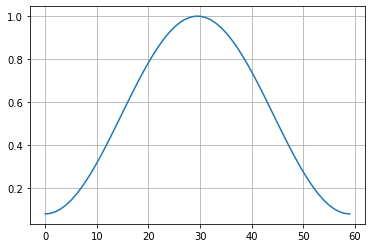

In [12]:
win_length = 60
hamming_vec = np.hamming(win_length)
plt.plot(hamming_vec)
plt.grid(True)
plt.show()

From above code snippets we understand that Hamming window function returns a vector of given window length, symmetric around the middle. Now let us examine what happens when we multiply a random vector to this hamming window vector. We will generate the random vector first then will plot it. Next we will multiply the vector with hamming window vector and finally will plot the resulted vector.

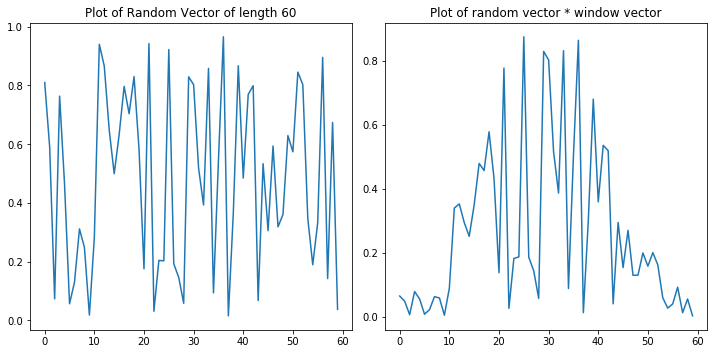

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
rand_vec_len = win_length
rand_vec = np.random.rand(rand_vec_len)
ax1.plot(rand_vec)
ax1.set_title('Plot of Random Vector of length 60')


ax2.plot(rand_vec * hamming_vec)
ax2.set_title('Plot of random vector * window vector')
plt.tight_layout(True)
plt.show()

In the above plot we can see after applying window function to the random vector , the values of the vector has been shrunk towards zero at the edges of the window boundaries avoiding discontinuities.  

Let us now apply this Hamming window function to each frame of our input signal. Each frame is 200 samples long. Hence our hamming window length would be 200.

In [14]:
win_length = frame_length
hamming_win = np.hamming(win_length)


above code will generate a hamming window of 200 length. we need to apply this same window vector to all of the 3361 frames. To do this we will prepare matrix of dimension 3361 by 200. and then will multiply this matrix with frame matrix. Lets save the resultant matrix in variable 'frame_window'.

In [15]:
hamming_win_matrx = np.tile(hamming_win, (frame_count,1))

frame_window = frames * hamming_win_matrx

Lets now plot the 1st frame to check how it looks like after applying window.

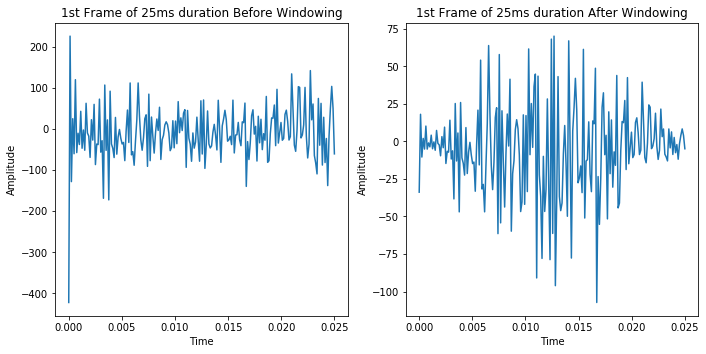

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
x = np.linspace(0,0.025,200)
y = frames[0]
ax1.set_title('1st Frame of 25ms duration Before Windowing')
ax1.plot(x,y)
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')

y = frame_window[0]
ax2.set_title('1st Frame of 25ms duration After Windowing')
ax2.plot(x,y)
plt.tight_layout(True)
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')
plt.show()

#### MFFC Step 3 - Discrete Fourier Transform (DFT) and Power Spectrum

Next we need to know how much energy the signal contains at different frequency bands. To know that first we need to transform the input signal into frequency domain. in **Frequency Domain** a signal is represented as a function of frequency . Which meaning signal can be ploted where x axis coresponds to frequencies of the signal and y axis corresponds to amplitude at different frequency bands. This transofrmation for discrete signal is doable uisng the concept **Discrete Fourier Transformation (DFT)**. Please go through the article [Fast Fourier Transformation](Core_Concepts.ipynb) to understand DFT in detail.  If you go through the link mentioned you will understand that DFT returns amplitudes in complex form ($a + b i$) where a is real part and b is imaginary part. it returns amplitude for different frequency bins. If we use fourier transform window N sample points then DFT returns ($N/2 + 1$) frequency bins.

We will set number of sample points in FFT to 512 sample points. **NFFT = 512**. So as per the nyquist limit theorem DFT would return (512/2 + 1 = 257) frequency bins. 

In [17]:
nfft = 512
dft_coef =np.fft.rfft(frame_window, nfft)
dft_coef.shape

(3361, 257)

The above code of DFT will have signanl amplitudes in complex form at 257 different frequency binsfor each 3361 frames. Lets show you the output of the DFT for 1st frame and first 10 frequency bins

In [18]:
# 1st Frame and amplitudes for first 5 frequency bins
dft_coef[0,:5]

array([-1060.27562117  +0.j        ,  -502.8026665 +831.10906539j,
         393.90619158+618.06814448j,   413.27402645-163.37779404j,
        -210.1129735 -234.86835401j])

As we know magnitude of any complex number ($a + b i$) is $\sqrt {a^2 + b^2}$. At the end we will need the magnitudes of the complex numbers returned by DFT because magnitude determines the amplitude of the signal. We will use numpy.absolute function to calculate the magnitudes of each complex numbers.

In [19]:
dft_magn = np.absolute(dft_coef)

# 1st Frame and amplitudes for first 5 frequency bins
dft_magn[0,:5]

array([1060.27562117,  971.3664602 ,  732.91903986,  444.39590966,
        315.13585221])

Lets plot 1st Frame at 257 different frequency bins. The plot of signal as a function of frequency bins , it is known as **Spectrum**

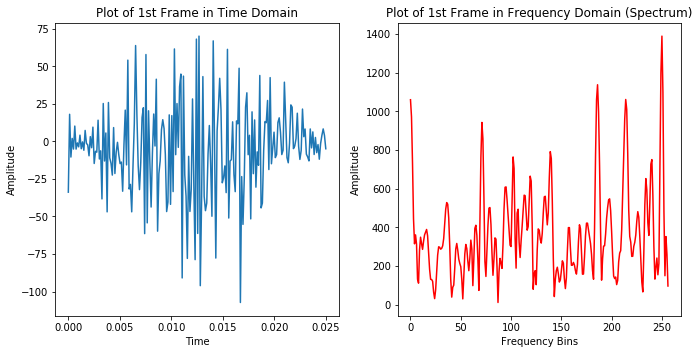

In [20]:
# Time Domain Plot
fig, (ax1, ax2) =plt.subplots(1,2, figsize=(10,5))
t = np.linspace(0,0.025,200)
y = frame_window[0,:]
ax1.set_title('Plot of 1st Frame in Time Domain')
ax1.plot(t,y)
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')

# Frequency Domain Plot
x = np.arange(0, 257)
y = dft_magn[0,:] # Only 1st Frame
ax2.plot(x,y,'r')

ax2.set_title('Plot of 1st Frame in Frequency Domain (Spectrum)')
ax2.set_xlabel('Frequency Bins')
ax2.set_ylabel('Amplitude')
plt.tight_layout(True)
plt.show()

##### Power Spectrum

Once we have transformed a signal from time domian into frequency domian, next step is  to calculate how much energy exists in the signal at each frequency domain. In signal processing, the energy  of a continuous or discrete time signal x(t) is defined as the area under the squared magnitude of the considered signal .And the spectral energy density describes the distribution of energy into frequency components composing the signal.  

Spectral Energy Density is calculates as $\frac{1}{N} |S_i(K)|^2$ where N = Number of sample points used in FFT (i.e. NFFT), i is the $i^th$ frame in the signal, K is the $K^th$ frequency bin. Hence $S_i(K)$ is the magnitude of the $i^th$ frame at $K^th$ frequency bin.

In [21]:
spec_eng_dens = 1.0 / nfft * np.square(dft_magn)

Lets now plot the spectral density energy of 1st frame.

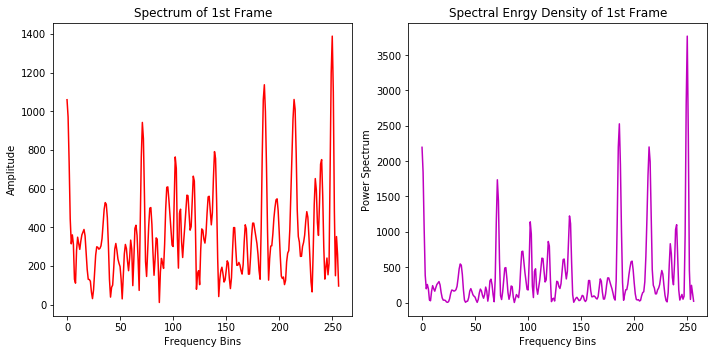

In [22]:
# Frequency Domain Plot
fig, (ax1, ax2) =plt.subplots(1,2, figsize=(10,5))
x = np.arange(0, 257)
y = dft_magn[0,:] # Only 1st Frame
ax1.plot(x,y,'r')

ax1.set_title('Spectrum of 1st Frame')
ax1.set_xlabel('Frequency Bins')
ax1.set_ylabel('Amplitude')

# Spectral Energy Desnity
y = spec_eng_dens[0,:]
ax2.plot(x,y,'m')
ax2.set_title('Spectral Enrgy Density of 1st Frame')
ax2.set_xlabel('Frequency Bins')
ax2.set_ylabel('Power Spectrum')

plt.tight_layout(True)
plt.show()

#### Mel Filterbanks

So far we have extracted energy distribution of the sinput signal across difeerent frequency bins. Next we need to extract energies within certain frequency ranges (Frequency Bands). Fo this purpose power spectrum is send through filters which filters energies within frequency bands. We creates array of such filters known as **Filter Banks** that seperate signal multiple components, each one carrying a single frequency sub band of the original signal.  

##### Mel Scale

Before we creates filter bank for our signal , first we need to concvert Frequency bins into Mel  Scale. Human hearing is less sensitive at higher frequencies roughly bove 1000 Hz. So we need a scale to adopt this property of human hearing into MFCC to improve the performence of speech recognition. To understand Mel Scale in detail please check out the link [Understanding of Mel Scale](Mel_Scale.ipynb). In General we will convert frequency bins corresponds to its Mel scale values.  

##### Filter Banks

In General practice a set of 20 - 40 traingular filters(standard count is 26 filters) is created.We will use **nfilter = 26**.To create filter bank (Array of filters) in the boundry of signal we need to set lowest frequency and highest frequency bands. We will set **lowest frequency to 0Hz** and **highest frequency to (sampling rate / 2)Hz**. so will set **low_freq_hz = 0** and **high_freq_hz = (8000/2) = 4000Hz**. Next we will convert these frequencies to Mel scale. We then need evently spaced filter points in mel scale. We will then convert the mel filter points to corresponding frequencies. Next we would find corresponding frequency bins within which the frequencies exists. 

In [23]:
low_freq_hz = 0
high_freq_hz = fs/2
print('Lower Frequency in Hz ', low_freq_hz)
print('Higher Frequency in Hz ', high_freq_hz)

low_freq_mel = (2595 * np.log10(1 + (low_freq_hz/700)))
high_freq_mel = (2595 * np.log10(1 + (high_freq_hz/700)))
print('\nLower Frequency in Mel Scale ', low_freq_mel)
print('Higher Frequency in Mel Scale ', high_freq_mel)

Lower Frequency in Hz  0
Higher Frequency in Hz  4000.0

Lower Frequency in Mel Scale  0.0
Higher Frequency in Mel Scale  2146.06452750619


In [24]:
nfilter = 26
filter_points_mel = np.linspace(low_freq_mel, high_freq_mel, nfilter+2)
print('Evently spaced Mel filter Points : \n', filter_points_mel)

Evently spaced Mel filter Points : 
 [   0.           79.48387139  158.96774278  238.45161417  317.93548556
  397.41935695  476.90322833  556.38709972  635.87097111  715.3548425
  794.83871389  874.32258528  953.80645667 1033.29032806 1112.77419945
 1192.25807084 1271.74194223 1351.22581362 1430.709685   1510.19355639
 1589.67742778 1669.16129917 1748.64517056 1828.12904195 1907.61291334
 1987.09678473 2066.58065612 2146.06452751]


In [25]:
# Mel points to Frequenies in Hertz
filter_points_hz = 700 * (10**(filter_points_mel/2595) - 1)
print('Filter Points in Frwquency Hz :\n ', filter_points_hz)

Filter Points in Frwquency Hz :
  [   0.           51.15171457  106.0412833   164.94184567  228.14650054
  295.96976465  368.74913769  446.84678175  530.65132352  620.57978815
  717.07967443  820.63118163  931.74959902 1050.98787008 1178.93934402
 1316.24072834 1463.57525727 1621.67609158 1791.32996697 1973.38110894
 2168.73543384 2378.36505685 2603.31312934 2844.69902982 3103.72393414
 3381.67679271 3679.94074455 4000.        ]


We can see that we have now 28 frequency points which are the points of each filter's start and end. So 1st triangular filter would start at frequency 0Hz and ends at frequency 51Hz , second filter starts at frequency 51Hz and ends at frequency 106Hz and so on. Our aim isto get energy at frequency bands, hence We will now convert these frequencies into corresponding frequency bins.

**Normalized frequency** is a unit of measurement of frequency equivalent to cycles/sample and is calculated as ($f / fs$) where $f$ is frequency , $fs$ is sampling rate. When we multiply this normalize frequency with NFFT plus 1 we get frequency bin number.

In [26]:
freq_bins = np.floor((nfft + 1) * filter_points_hz /fs)
print('Frequency Bins corresponds to frequencies : \n', freq_bins)

Frequency Bins corresponds to frequencies : 
 [  0.   3.   6.  10.  14.  18.  23.  28.  34.  39.  45.  52.  59.  67.
  75.  84.  93. 103. 114. 126. 139. 152. 166. 182. 199. 216. 235. 256.]


<img src='Images/Filter_Formula.png' width='300px' align='right'>
So we get 28 frequency bins corresponds to frequencies. The filters we will create to be a triangular filter. Which means 1st filter starts at bin 0 ,linearly increases and reaches its peak at bin 3, and then linearly decreases and reaches to zero at bin 6. 2nd filter should starts at bin 3, reaches its peak at bin 6 and then ends at bin 10. This is how filters to be created. The figure at right shows the formual to achieve traingular filters.  

Lets now implements filters. So idea is we will have 26 filters , each of these filters will have 28 frequency bins 0 to 256.  

First we will create an empty matrix of 26 rows and 257 columns where rows corresponds to each filter and columns corresponds to frequency bin numbers. To derive number of columns we will use formula (NFFT // 2 + 1). Plus 1 is to get freqeucny bin number 256. Once after creating this zero matrix we will use the traingular formula to create filters.

In [27]:
fbank = np.zeros((nfilter, nfft//2 + 1))
print('Empty Filter bank of {} filters and {} freq bins '.format(nfilter,  nfft//2 + 1 ))
pd.DataFrame(fbank)

Empty Filter bank of 26 filters and 257 freq bins 


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Traingular Formula
for m in range(1, nfilter + 1):
    f_m_minus = int(freq_bins[m-1])
    f_m = int(freq_bins[m])
    f_m_plus = int(freq_bins[m+1])
    
    for k in range(f_m_minus, f_m):
        fbank[m-1, k] = (k - freq_bins[m-1]) / (freq_bins[m] - freq_bins[m-1])
    
    for k in range(f_m , f_m_plus):
        fbank[m-1, k] = (freq_bins[m+1] - k) / (freq_bins[m+1] - freq_bins[m])

display(pd.DataFrame(fbank))

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0.0,0.333333,0.666667,1.0,0.666667,0.333333,0.0,0.00,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.000000,0.000000,0.0,0.333333,0.666667,1.0,0.75,0.5,0.25,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.25,0.5,0.75,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Look at the filter bank matrix above.We wanted 1st filter to start at bin number 0 and linearly increases towards its peak at bin number 3 and then linearly decreases towards zer at bin number 6. Just observe the row zero in the matrix you will see expected traingular filter values from bin 0 to bin 6.  

Let use plot these filters to visulaise.

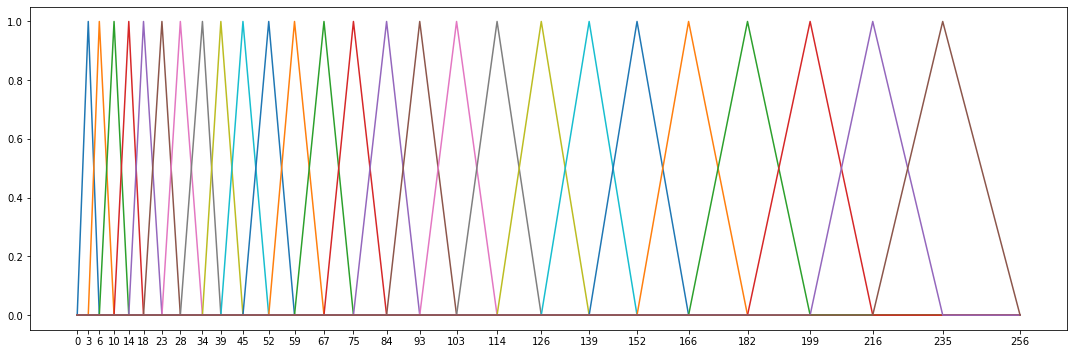

In [29]:
plt.figure(figsize=(15,5))
plt.plot(fbank[:][:].T)
plt.tight_layout(True)
plt.xticks(freq_bins)
plt.tight_layout(True)
plt.show()

We will now pass our spectral energy density to these 26 filters for each frame to get energies at these frequency bins. 

In [30]:
Mel_Spectrum = np.dot(spec_eng_dens, fbank.T)
Mel_Spectrum.shape

(3361, 26)

So we have energy distribution for each 3361 frames at these 26 traingular frames. In general the human response to signal level is logarithmic; humans are less sensitive to slight differences in amplitude at high amplitudes than at low amplitudes. So we need to take log of thse mel spectrum.

In [31]:
log_mel_spectrum = np.log10(Mel_Spectrum)

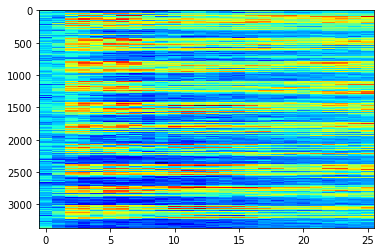

In [32]:
plt.imshow(log_mel_spectrum, cmap=plt.cm.jet, aspect='auto')
plt.show()

#### MFCC Step 4 - Discrete Cosine Transform (DCT)  

We have seen that filters are overlapping and the filterbank energies are correlated with each other. This may cause some problem in some ML algos. DCT helps to decorrelate the energies.   

Lets plot seaborn's heatmap on log mel spectram array to check colinearity between each 26 features.

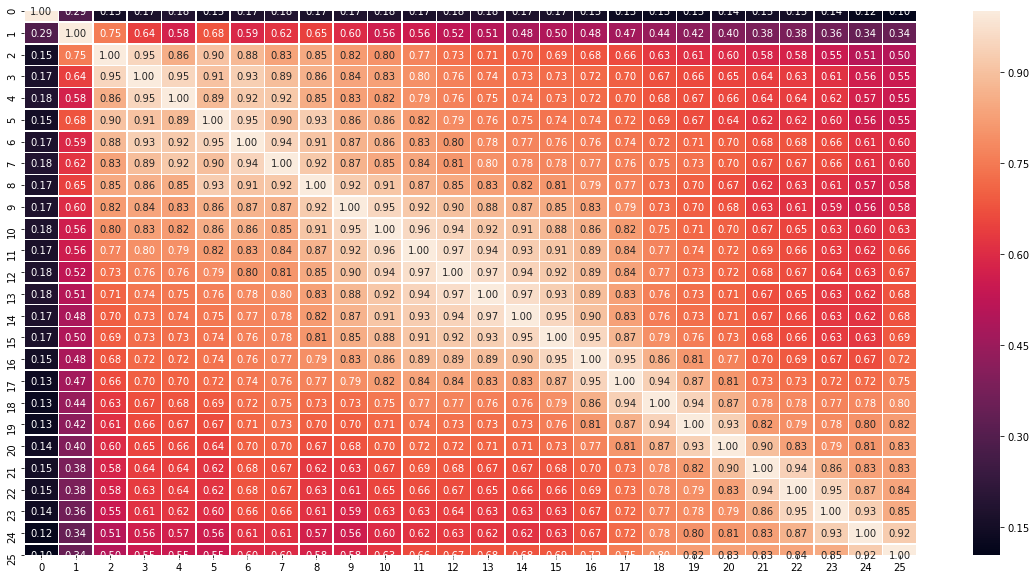

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig= plt.subplots(figsize=(20,10))
sns.heatmap(pd.DataFrame(log_mel_spectrum).corr(), annot=True,square=False,fmt=".2f",linewidths=.5)
plt.show()

If we notice above heatmp carefully we will see there are many feature pairs are corelated to each other (where corelation value is greater than 0.9).   

We will apply DCT(Discrete Cosine Transform) to overcome the corelation problem.

In [51]:
from scipy.fftpack import dct

In [52]:
mfcc = dct(log_mel_spectrum, type=2, axis=1, norm='ortho')[:,:13]

In [53]:
(nframes, ncoef) = mfcc.shape
n = np.arange(ncoef)
cep_lifter =22
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift

Below table shows the final set of 13 MFCC features on our input audio signal.

In [63]:
pd.DataFrame(mfcc)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,16.751536,-4.914108,0.640706,1.091130,3.791773,-1.613768,3.890213,1.768490,1.527657,0.646814,-7.999279,-0.386364,3.976957
1,17.519536,-3.641290,-0.663702,4.191597,6.293668,-4.290496,1.042087,-8.549908,-3.090074,4.390944,-8.368601,-6.900800,5.451164
2,17.124639,-5.862538,0.683690,3.374111,2.139924,-6.874089,-1.188578,-10.359964,3.593038,11.297794,-1.567416,1.129346,7.576233
3,17.184442,-5.576654,0.545801,2.725292,4.355638,-1.749793,-2.223714,-6.316666,4.053480,7.359129,-1.010650,-2.289391,-0.515059
4,16.954236,-6.009356,2.679777,6.786514,-1.380903,-0.509967,6.703476,-11.819883,0.123802,9.281686,-2.206551,-4.091550,6.859807
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356,12.031806,-1.087427,7.197449,7.510724,4.692366,1.366829,-0.719928,1.822633,10.544179,8.020465,-1.002815,-5.788083,-5.940210
3357,11.974290,-1.732589,4.508755,4.508666,5.912134,-1.388365,-0.602563,5.825911,8.802191,4.929015,-1.765623,-0.477888,-0.751941
3358,12.195171,-1.743782,4.314569,5.762689,1.328055,-0.483215,7.339796,13.252779,3.753771,-1.006748,-0.798264,3.782545,-2.008399
3359,12.244513,-1.590432,5.384646,5.434875,3.269734,2.879663,5.420260,5.920457,1.489121,1.889598,3.674343,0.609038,1.316386
